# Data Science Internship
# - Anisha Walde

# Golden Project 01: Web Traffic Times Series Forecasting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.callbacks import ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv("webtraffic.csv")

In [3]:
data.head()

,Hour Index,Sessions
0,0,1418159421
1,1,1113769116
2,2,919158921
3,3,822352824
4,4,735526737


In [4]:
data.tail()

,Hour Index,Sessions
4891,4891,2555880561
4892,4892,2454084459
4893,4893,2405182410
4894,4894,2356280361
4895,4895,1987019991


In [5]:
data.shape

(4896, 2)

In [6]:
data.size

9792

In [7]:
data.describe()

,Hour Index,Sessions
count,4896.000000,4.896000e+03
mean,2447.500000,2.249544e+09
std,1413.497789,9.064586e+08
min,0.000000,5.708566e+08
25%,1223.750000,1.528938e+09
50%,2447.500000,2.086820e+09
75%,3671.250000,2.974043e+09
max,4895.000000,6.061858e+09


In [8]:
data.isna().sum()

Hour Index    0
Sessions      0
dtype: int64

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4896 entries, 0 to 4895
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Hour Index  4896 non-null   int64
 1   Sessions    4896 non-null   int64
dtypes: int64(2)
memory usage: 76.6 KB


In [10]:
# Extract sessions data
sessions = data['Sessions'].values

# Visualized Dataset

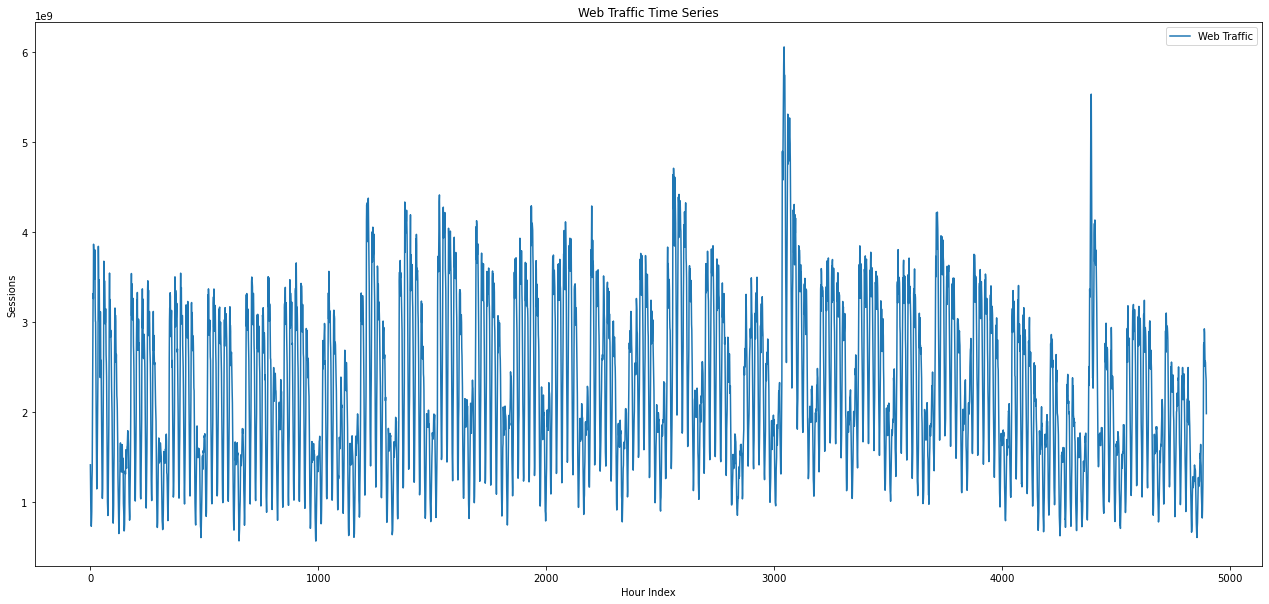

In [11]:
# Visualize the time series
plt.figure(figsize=(22, 10))
plt.plot(data['Hour Index'], data['Sessions'], label='Web Traffic')
plt.title('Web Traffic Time Series')
plt.xlabel('Hour Index')
plt.ylabel('Sessions')
plt.legend()
plt.show()


This curve represents various early session counts, revealing recurring patterns in the time series data. Periodically, the traffic volume experiences a decline at nearly equal intervals. Additionally, notable spikes in traffic are observed sporadically throughout the plot.

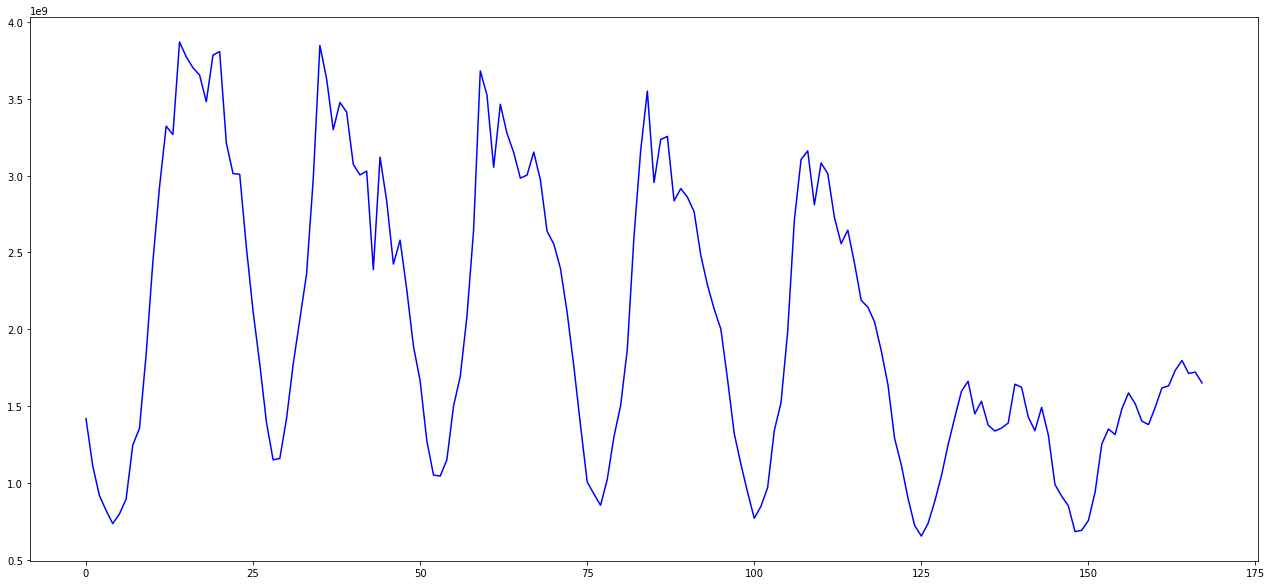

In [13]:
# Visualize the first week's data
sample = sessions[:168]
ar = np.arange(len(sample))
plt.figure(figsize=(22, 10))
plt.plot(ar, sample, 'b')
plt.show()

# Data preparation

In [14]:
def prepare_data(sequence, window_size):
    inputs = []
    outputs = []

    for i in range(len(sequence) - window_size):
        input_sequence = sequence[i:i + window_size]
        output_value = sequence[i + window_size]

        inputs.append(input_sequence)
        outputs.append(output_value)

    return np.array(inputs), np.array(outputs)

window_size = 168
input_data, output_data = prepare_data(sessions, window_size)
print(len(input_data))

4728


We have set the sequence length to 168 hours, which corresponds to a week. Consequently, we are generating input sequences representing one-week intervals. The total number of sequences now exceeds 4700.

# Train-Test Split

In [15]:
ind = int(0.9 * len(input_data))
X_train, y_train = input_data[:ind], output_data[:ind]
X_test, y_test = input_data[ind:], output_data[ind:]

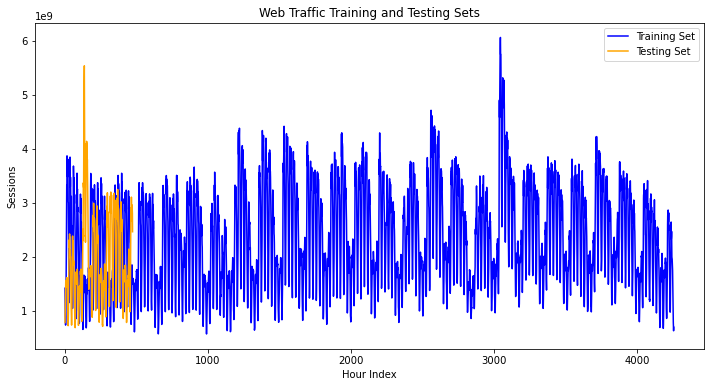

In [16]:
# Visualize Training and Testing Sets
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(X_train[:, 0], label='Training Set', color='blue')  
ax.plot(X_test[:, 0], label='Testing Set', color='orange')   

ax.set_title('Web Traffic Training and Testing Sets')
ax.set_xlabel('Hour Index')
ax.set_ylabel('Sessions')
ax.legend()

plt.show()


# Data scaling

In [17]:
X_scaler = StandardScaler()
X_train_flat = X_train.reshape(X_train.shape[0], -1)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

X_train_scaled = X_scaler.fit_transform(X_train_flat).reshape(X_train.shape)
X_test_scaled = X_scaler.transform(X_test_flat).reshape(X_test.shape)

In [18]:
y_train = y_train.reshape(len(y_train), 1)
y_test = y_test.reshape(len(y_test), 1)

y_scaler = StandardScaler()
y_train = y_scaler.fit_transform(y_train)[:, 0]
y_test = y_scaler.transform(y_test)[:, 0]

In [19]:
# Reshape input sequences to 3D
X_train = X_train_scaled
X_test = X_test_scaled

print(X_train.shape)

(4255, 168)


# Build and Train Model

In [20]:
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], 1)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='linear'))
model.compile(loss='mse', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 74881 (292.50 KB)
Trainable params: 74881 (292.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [21]:
# Compile the model
checkpoint_callback = ModelCheckpoint('best_model.hdf5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# Train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[checkpoint_callback])

Epoch 1/30
133/133 [==============================] - ETA: 0s - loss: 0.1536
Epoch 1: val_loss improved from inf to 0.03784, saving model to best_model.hdf5
133/133 [==============================] - 16s 101ms/step - loss: 0.1536 - val_loss: 0.0378
Epoch 2/30
133/133 [==============================] - ETA: 0s - loss: 0.0423
Epoch 2: val_loss improved from 0.03784 to 0.02852, saving model to best_model.hdf5
133/133 [==============================] - 11s 85ms/step - loss: 0.0423 - val_loss: 0.0285
Epoch 3/30
133/133 [==============================] - ETA: 0s - loss: 0.0371
Epoch 3: val_loss did not improve from 0.02852
133/133 [==============================] - 14s 108ms/step - loss: 0.0371 - val_loss: 0.0303
Epoch 4/30
133/133 [==============================] - ETA: 0s - loss: 0.0343
Epoch 4: val_loss improved from 0.02852 to 0.02558, saving model to best_model.hdf5
133/133 [==============================] - 16s 120ms/step - loss: 0.0343 - val_loss: 0.0256
Epoch 5/30
133/133 [==========

In [22]:
model.load_weights('best_model.hdf5')

# The model on the training set
mse = model.evaluate(X_train, y_train)
print("Mean Square Error:", mse)

133/133 [==============================] - 4s 32ms/step - loss: 0.0149
Mean Square Error: 0.014905373565852642


# Forecasting 

In [23]:
def Forecast(X_test, no_of_pred, ind):
    predictions = []
    temp = X_test[ind]
    for i in range(no_of_pred):
        pred = model.predict(temp.reshape(1, -1, 1))[0][0]
        temp = np.insert(temp, len(temp), pred)
        predictions.append(pred)
        temp = temp[1:]
    return predictions

1/1 [==============================] - 0s 28ms/step


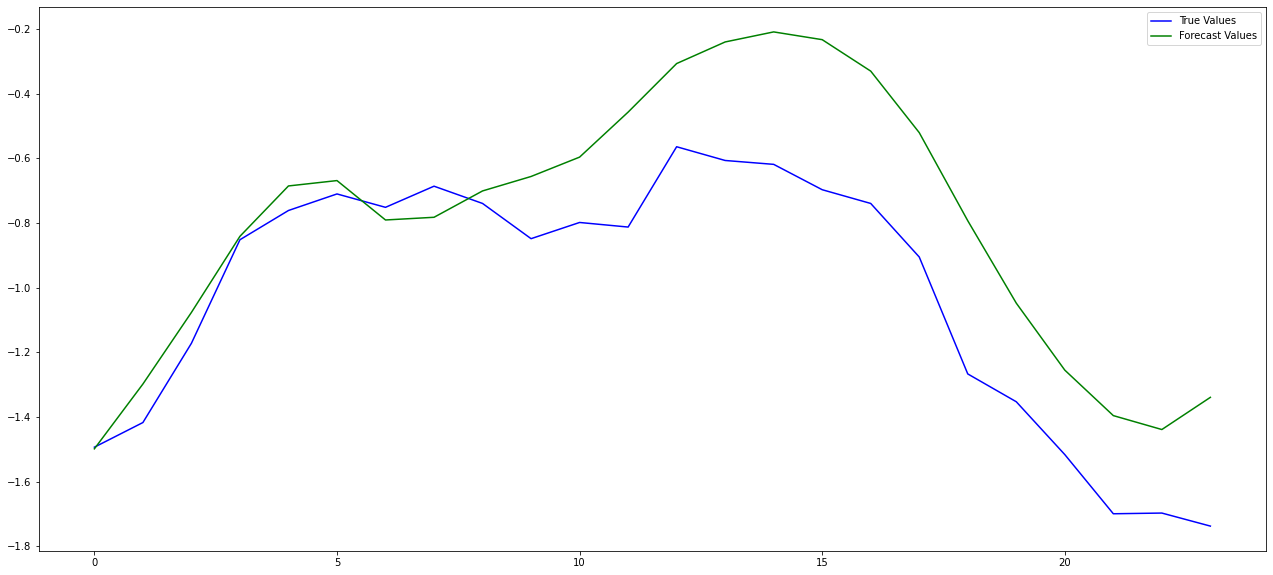

In [24]:
# Forecast using the trained model
no_of_pred = 24
ind = 72
y_pred = Forecast(X_test, no_of_pred, ind)
y_true = y_test[ind:ind + no_of_pred]

# Plot real vs forecast values
plt.figure(figsize=(22, 10))
plt.plot(np.arange(len(y_true)), y_true, 'b', label='True Values')
plt.plot(np.arange(len(y_pred)), y_pred, 'g', label='Forecast Values')
plt.legend()
plt.show()

**Thank you**